# Cluster Lens Simulation Interface

This notebook shows the current progress in the group and cluster scale simulations.

Implemented:
* NFWCluster deflector class: a NFW halo and subhalos that can be any deflector, accesible through the Deflector interface
* Integration with Lens interface to simulate lens related quanities.

Not (yet) implemented:
* Draw halo and subhalo population
* Catalog of cluster halos and cluster members
* Integration with LensPop

## Setup

In [1]:
from slsim.Deflectors.deflector import Deflector
from slsim.lens import Lens
from slsim.lens_pop import LensPop

from astropy.cosmology import FlatLambdaCDM

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
from astropy import units as u
from lenstronomy.Util import param_util
import copy

from matplotlib.patches import Ellipse

# to simulate the resulting lens
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.DES import DES
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.Plots.plot_util import scale_bar
from astropy.visualization import ZScaleInterval

Generate a population of sources and elliptical deflectors

In [51]:
np.random.seed(0)

In [52]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = u.Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 26, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 26, "z_min": 0.1, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_type="elliptical",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    cosmo=cosmo,
)

This is for visualization

In [4]:
# Instrument setting from pre-defined configurations

DES_g = DES(band="g", psf_type="GAUSSIAN", coadd_years=3)
DES_r = DES(band="r", psf_type="GAUSSIAN", coadd_years=3)
DES_i = DES(band="i", psf_type="GAUSSIAN", coadd_years=3)
des = [DES_g, DES_r, DES_i]

LSST_g = LSST(band="g", psf_type="GAUSSIAN", coadd_years=10)
LSST_r = LSST(band="r", psf_type="GAUSSIAN", coadd_years=10)
LSST_i = LSST(band="i", psf_type="GAUSSIAN", coadd_years=10)
lsst = [LSST_g, LSST_r, LSST_i]

Roman_g = Roman(band="F062", psf_type="PIXEL", survey_mode="wide_area")
Roman_r = Roman(band="F106", psf_type="PIXEL", survey_mode="wide_area")
Roman_i = Roman(band="F184", psf_type="PIXEL", survey_mode="wide_area")
roman = [Roman_g, Roman_r, Roman_i]

In [5]:
numpix = 200  # number of pixels per axis of the image to be modelled

# here we define the numerical options used in the ImSim module.
# Have a look at the ImageNumerics class for detailed descriptions.
# If not further specified, the default settings are used.
kwargs_numerics = {}


def simulate_rgb(ConfigList, size, kwargs_numerics, contrast=0.1):
    band_b, band_g, band_r = ConfigList
    kwargs_b_band = band_b.kwargs_single_band()
    kwargs_g_band = band_g.kwargs_single_band()
    kwargs_r_band = band_r.kwargs_single_band()

    # set number of pixels from pixel scale
    pixel_scale = kwargs_g_band["pixel_scale"]
    numpix = int(round(size / pixel_scale))

    sim_b = SimAPI(
        numpix=numpix, kwargs_single_band=kwargs_b_band, kwargs_model=kwargs_model
    )
    sim_g = SimAPI(
        numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model
    )
    sim_r = SimAPI(
        numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model
    )

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_b = sim_b.image_model_class(kwargs_numerics)
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)

    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_b.magnitude2amplitude(
        kwargs_lens_light_mag_g, kwargs_source_mag_g
    )
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_g.magnitude2amplitude(
        kwargs_lens_light_mag_r, kwargs_source_mag_r
    )
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_r.magnitude2amplitude(
        kwargs_lens_light_mag_i, kwargs_source_mag_i
    )

    image_b = imSim_b.image(
        lenstronomy_kwargs["kwargs_lens"],
        kwargs_source_g,
        kwargs_lens_light_g,
        kwargs_ps_g,
    )
    image_g = imSim_g.image(
        lenstronomy_kwargs["kwargs_lens"],
        kwargs_source_r,
        kwargs_lens_light_r,
        kwargs_ps_r,
    )
    image_r = imSim_r.image(
        lenstronomy_kwargs["kwargs_lens"],
        kwargs_source_i,
        kwargs_lens_light_i,
        kwargs_ps_i,
    )

    # add noise
    image_b += sim_b.noise_for_model(model=image_b)
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)

    img = make_zscale_rgb(image_r, image_g, image_b, contrast=contrast)
    data_class = sim_b.data_class
    return img, data_class

In [6]:
def make_zscale_rgb(r, g, b, mask=None, **kwargs):
    if mask is None:
        mask = np.ones(r.shape, dtype=bool)
    zscale = ZScaleInterval(**kwargs)
    rmin, rmax = zscale.get_limits(r[mask])
    gmin, gmax = zscale.get_limits(g[mask])
    bmin, bmax = zscale.get_limits(b[mask])
    rgb = np.dstack(
        (
            (r - rmin) / (rmax - rmin),
            (g - gmin) / (gmax - gmin),
            (b - bmin) / (bmax - bmin),
            mask.astype(float),
        )
    )
    rgb = np.clip(rgb, 0, 1)
    rgb = (rgb * 255.999).astype(np.uint8)
    return rgb

## Basic Example

This example shows the implemented features. It generates a lens from an slsim sampled source, and a halo + subhalos with manually set parameters. It is not intended to be a realistic cluster.

Set seed for reproduction

In [53]:
np.random.seed(1)

In [54]:
halo_dict = {
    "halo_mass": 1e14,
    "concentration": 5,  # TODO: set concentration from mass-redshift-concentration relation
    "e1_mass": 0.1,
    "e2_mass": -0.1,
    "z": 0.42,
}

In [55]:
subhalos_table = Table.read('../tests/TestData/subhalos_table.fits')
subhalos_table

z,M,coeff,ellipticity,physical_size,stellar_mass,angular_size,mag_g,mag_r,mag_i,mag_z,mag_Y,vel_disp,e1_light,e2_light,e1_mass,e2_mass,n_sersic,center_x,center_y
,,,,kpc,,rad,,,,,,,,,,,,,
float64,float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.40961161750606623,-17.74659351948313,0.014461312431650886 .. 0.0017553671438891554,0.2910638099896307,0.6126468465532885,6134707325.985248,5.449207115062017e-07,24.980052525073667,23.595940832611404,23.07059085953089,22.76766104854414,22.57663477819682,238.6881226614444,-0.04528497553751,0.1416914374289071,-0.0019891604503226743,0.026829555556416532,4.0,2.1991997927160987,3.919514530899428
0.4116468964498543,-21.33484897934431,0.23285635798664925 .. 0.0006941668698218637,0.15174652869004476,3.7017292439367973,240837649679.1357,3.282729405263374e-06,21.567499195041215,20.026445329337342,19.363187222380752,18.981620021271375,18.75254269621525,275.0041773084429,-0.05236187054892784,0.05551789525462122,-0.06511420472541432,0.08282581103144096,4.0,0.8693181053414824,0.8279203242106586
0.357742197708797,-17.70016474314204,0.11749415182192821 .. 0.0009963705918894985,0.09247542465242468,0.22517235412009645,8172885735.947244,2.1789243925349325e-07,24.558320753535146,23.174654552345824,22.60350168788489,22.273007291380058,22.085215345311457,239.48534781261813,0.023416486644143208,0.03998480716073247,0.08818194961203064,0.2393539252201014,4.0,-1.4313058824457068,-1.2971386999655654
0.43321408312382476,-21.624890597703676,0.08464660764530811 .. 0.0009006445161237372,0.21060142972690385,2.3919434702572593,260035388352.9656,2.058095711291011e-06,21.000557844900243,19.926803223244768,19.33049856621807,19.010991686213686,18.79413875740036,276.91021844529143,0.10590581383265181,0.011186271676403,0.01235901177287892,0.0008661401605979852,4.0,0.5913335287465081,9.373582206571212
0.40664485199633355,-20.323923719919286,0.04239681022192635 .. 0.000642978918452646,0.3224955343138368,1.4049504867155502,82384629856.09811,1.2551227098076372e-06,22.470274300452132,20.990325400071697,20.39528372488079,20.065144547510236,19.87646729406098,256.2982137470725,-0.029037278604714677,0.1631091572224996,-0.01927975004064865,0.10069437796471338,4.0,7.369516112011384,5.00295994058848
0.4376178752381092,-18.7936006252479,0.14206729280250247 .. 0.0016625409960951707,0.1647023203467217,0.4254001095167009,20230857612.75885,3.6388064941698217e-07,24.21872306092851,22.799104546193014,22.146352378632578,21.79395982665163,21.565756843217763,243.85574045984882,-0.0754136386484834,0.03446838704341557,-0.018110945492180335,0.008948504939325357,4.0,-5.005510169566389,-2.681860992222449
0.4099796727538578,-16.512141575263364,0.030875540197497997 .. 0.0002203614733351139,0.08513893600336805,0.11686325540198512,2792649800.8751807,1.038882899755727e-07,26.39549320727873,24.83029836517223,24.182210285777888,23.840503093758993,23.65161860291757,236.99130742917959,-0.0424965956722835,0.003577249480990931,0.09694801706010811,-0.017100807340409214,4.0,7.644046541105355,9.268773948886318
0.4127768279274331,-15.721344032029277,0.07559942601411682 .. 0.00027449606564557876,0.26668668280998875,0.2985039673322858,1283273119.2410483,2.642817163990263e-07,27.04262960934578,25.65013657080857,25.022279241903632,24.68099549945051,24.48110194359954,235.93973169995965,-0.0382039211203908,0.1303179954461028,-0.016311796145999414,0.07570778350877454,4.0,16.833942804162128,-6.2521801083342154


In [56]:
subhalos_list = [
            Deflector(deflector_type="EPL", deflector_dict=subhalo)
            for subhalo in subhalos_table
        ]
len(subhalos_list)

10

Initialize a ClusterLens object to combine the components into a Lenstronomy model.

Draw sources until find a valid lens

In [57]:
max_try = 100
i = 0
while i < max_try:
    source_dict = gg_lens_pop._sources.draw_source()
    
    cluster_lens = Lens(
                    source_dict=source_dict,
                    deflector_dict=halo_dict,
                    deflector_kwargs={"subhalos_list": subhalos_list},
                    deflector_type="NFW_CLUSTER",
                    lens_equation_solver="lenstronomy_default",
                    cosmo=cosmo,
                )
    i += 1
    if cluster_lens.validity_test(max_image_separation=50.0):
        print("valid!")
        break

valid!


In [58]:
cluster_lens.einstein_radius_deflector

15.87579644908867

In [59]:
lenstronomy_components, lenstronomy_kwargs = cluster_lens.lenstronomy_kwargs(band="g")

Visualize the result

In [60]:
# g-band
kwargs_source_mag_g = lenstronomy_kwargs["kwargs_source"]
kwargs_lens_light_mag_g = lenstronomy_kwargs["kwargs_lens_light"]

# r-band
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_r[i]["magnitude"] = subhalos_table[i]["mag_r"]

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]["magnitude"] = source_dict["mag_r"]

# i-band
kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_i[i]["magnitude"] = subhalos_table[i]["mag_i"]

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]["magnitude"] = source_dict["mag_i"]

Use Lenstronomy sim API to visualize the result

In [61]:
kwargs_model = {
    "lens_model_list": lenstronomy_components[
        "lens_model_list"
    ],  # list of lens models to be used
    "lens_light_model_list": lenstronomy_components[
        "lens_light_model_list"
    ],  # list of unlensed light models to be used
    "source_light_model_list": lenstronomy_components[
        "source_light_model_list"
    ],  # list of extended source models to be used, here we used the interpolated real galaxy
}

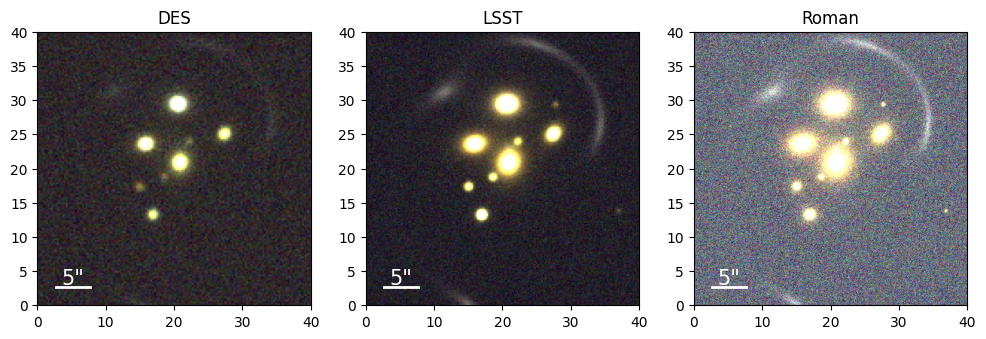

In [62]:
size = 40.0  # width of the image in units of arc seconds

img_des, coords_des = simulate_rgb(
    des, size=size, kwargs_numerics=kwargs_numerics, contrast=0.1
)
img_lsst, coords_lss = simulate_rgb(
    lsst, size=size, kwargs_numerics=kwargs_numerics, contrast=0.1
)
img_roman, coords_roman = simulate_rgb(
    roman, size=size, kwargs_numerics=kwargs_numerics, contrast=0.5
)

f, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.imshow(img_des, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("DES")
# coordinate_arrows(ax, d=1, coords=coords_des, color='w', font_size=15, arrow_size=0.05)
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)

ax = axes[1]
ax.imshow(img_lsst, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("LSST")
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)

ax = axes[2]
ax.imshow(img_roman, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("Roman")
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)
plt.show()

## Example drawing redMaPPer cluster

Draw a cluster from DES redMaPPer catalog and assign an slsim deflector for each cluster member and a cluster-sized halo based in scaling relations.

This feature is not yet implemented in slsim, but is a possible way of making realistic cluster lenses.

Set seed for reproduction

In [63]:
np.random.seed(1)

redMaPPer cluster catalog

In [64]:
clusters = Table.read('../data/redMaPPer/clusters.fits')
members = Table.read('../data/redMaPPer/members.fits')

Draw a cluster as an example

In [65]:
cluster_id = np.random.choice(clusters['ID'])
cluster_data = clusters[clusters['ID'] == cluster_id][0]
members_data = members[members['ID'] == cluster_id]
members_data.sort('R') # sort by distance to the center

In [66]:
_bcgs_ids = [cluster_data[f'ID{i}'] for i in range(4)]
_bcgs_iprobs = [cluster_data[f'PCen{i}'] for i in range(4)]
_bcgs_iprobs = np.array(_bcgs_iprobs) / np.sum(_bcgs_iprobs)
bcg_id = np.random.choice(_bcgs_ids, p=_bcgs_iprobs)
bcg_data = members_data[members_data['ObjID'] == bcg_id]

In [67]:
members_data['center_x'] = (members_data['RAJ2000'] - bcg_data['RAJ2000']) * u.deg.to(u.arcsec)
members_data['center_y'] = (members_data['DEJ2000'] - bcg_data['DEJ2000']) * u.deg.to(u.arcsec)

In [68]:
members_data = members_data['ID', 'ObjID', 'PMem', 'R', 'center_x', 'center_y', 'gmag', 'rmag', 'imag', 'zmag']
members_data.rename_columns(['gmag', 'rmag', 'imag', 'zmag'], ['mag_g', 'mag_r', 'mag_i', 'mag_z'])

Draw some deflectors

In [69]:
n_deflectors = 5000
deflectors_table = []
for _ in range(n_deflectors):
    deflectors_table.append(gg_lens_pop._lens_galaxies.draw_deflector())
deflectors_table = vstack(deflectors_table)

Assign a deflector for each cluster member based on magnitude and color

In [70]:
from scipy.spatial.distance import cdist


def assing_similar_deflector(members_table, 
                             deflectors_table, 
                             cluster_z, 
                             cosmo=None, 
                             bands=('g', 'r', 'i', 'z')
                            ):
    mag_members = np.stack([members_table[f'mag_{b}'].data for b in bands], axis=1)
    mag_deflectors = np.stack([deflectors_table[f'mag_{b}'].data for b in bands], axis=1)
    distance = cdist(mag_members, mag_deflectors, metric='euclidean')
    nearest_neighbors_indices = distance.argmin(axis=1)
    similar_deflectors = deflectors_table[nearest_neighbors_indices]
    return similar_deflectors


# def assing_similar_deflector(members_table, 
#                              deflectors_table, 
#                              cluster_z, 
#                              cosmo=None, 
#                              bands=('g', 'r', 'i', 'z')
#                             ):
#     mag_members = [members_table[f'mag_{b}'].data for b in bands]
#     mag_deflectors = [deflectors_table[f'mag_{b}'].data for b in bands]
#     dist_mod_members = -5 * np.log10(cosmo.luminosity_distance(cluster_z) / (10 * u.pc)) * np.ones(len(members_table))
#     dist_mod_deflectors = -5 * np.log10(cosmo.luminosity_distance(deflectors_table['z'].data) / (10 * u.pc))
#     distance = cdist(np.stack([*mag_members, dist_mod_members], axis=1), 
#                      np.stack([*mag_deflectors, dist_mod_deflectors], axis=1), 
#                      metric='euclidean')
#     nearest_neighbors_indices = distance.argmin(axis=1)
#     similar_deflectors = deflectors_table[nearest_neighbors_indices]
#     return similar_deflectors

In [71]:
subhalos_table = assing_similar_deflector(members_data, deflectors_table, 
                                          cluster_data['zlambda'], cosmo=cosmo,
                                          bands=('g', 'r', 'i', 'z'))
subhalos_table = hstack([subhalos_table, members_data['ID', 'ObjID', 'PMem', 'center_x', 'center_y']])

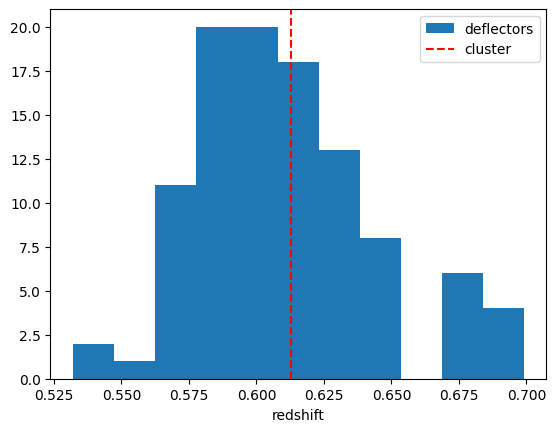

In [26]:
plt.hist(subhalos_table['z'], bins='auto', label='deflectors')
plt.axvline(cluster_data['zlambda'], c='r', ls='--', label='cluster')
plt.xlabel('redshift')
plt.legend()
plt.show()

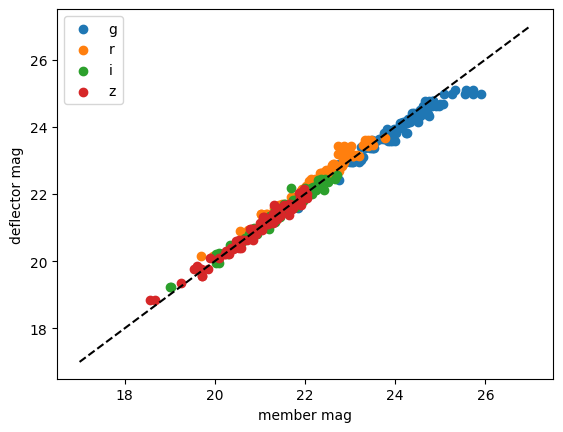

In [27]:
plt.scatter(members_data['mag_g'], subhalos_table['mag_g'], label='g')
plt.scatter(members_data['mag_r'], subhalos_table['mag_r'], label='r')
plt.scatter(members_data['mag_i'], subhalos_table['mag_i'], label='i')
plt.scatter(members_data['mag_z'], subhalos_table['mag_z'], label='z')
plt.plot(np.linspace(17, 27), np.linspace(17, 27), 'k--')
plt.xlabel('member mag')
plt.ylabel('deflector mag')
plt.legend()
plt.show()

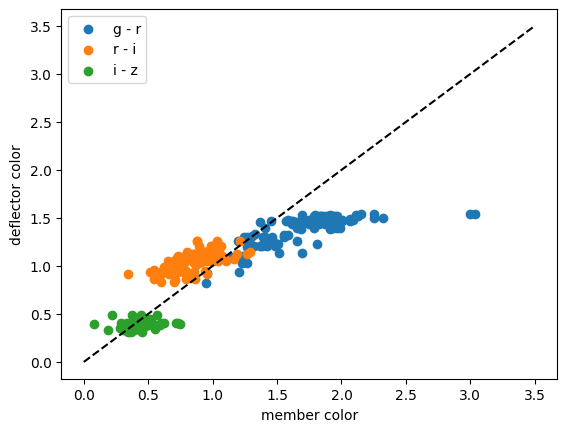

In [28]:
plt.scatter(members_data['mag_g'] - members_data['mag_r'], subhalos_table['mag_g'] - subhalos_table['mag_r'], label='g - r')
plt.scatter(members_data['mag_r'] - members_data['mag_i'], subhalos_table['mag_r'] - subhalos_table['mag_i'], label='r - i')
plt.scatter(members_data['mag_i'] - members_data['mag_z'], subhalos_table['mag_i'] - subhalos_table['mag_z'], label='i - z')
plt.plot(np.linspace(0, 3.5), np.linspace(0, 3.5), 'k--')
plt.xlabel('member color')
plt.ylabel('deflector color')
plt.legend()
plt.show()

Set NFW halo parameters from mass-richness relation

In [72]:
halo_mass = 1e14 * (cluster_data['lambda'] / 20)**1.4

Set the halo ellipticity from subhalo distribution

In [73]:
cov_matrix = np.cov(np.stack([subhalos_table['center_x'], subhalos_table['center_y']], axis=1), 
                    aweights=subhalos_table['stellar_mass'], 
                    rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
largest_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
phi = np.arctan2(largest_eigenvector[1], largest_eigenvector[0])
q = np.sqrt(np.min(eigenvalues) / np.max(eigenvalues))
e1, e2 = param_util.phi_q2_ellipticity(phi, q)

Visualize the members distribution, along with an ellipse describing the shape of the halo

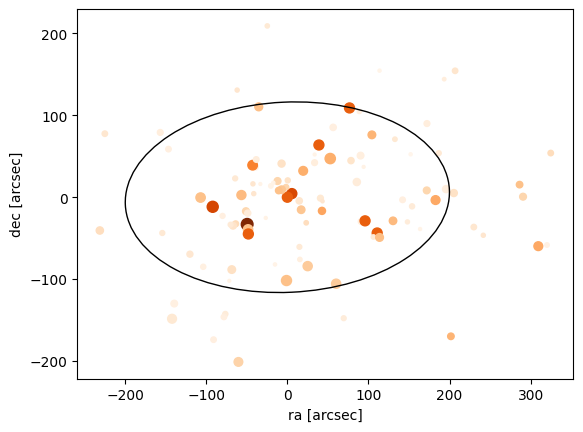

In [74]:
plt.scatter(subhalos_table['center_x'], subhalos_table['center_y'], s=subhalos_table['physical_size']*10, c=subhalos_table['stellar_mass'], cmap='Oranges')
plt.gca().add_patch(Ellipse((0, 0), 400, 400*q, angle=np.rad2deg(phi), facecolor='none', edgecolor='k'))
plt.xlabel('ra [arcsec]')
plt.ylabel('dec [arcsec]')
plt.show()

In [75]:
halo_dict = {
    "halo_mass": halo_mass,
    "concentration": 5,  # TODO: set concentration from mass-redshift-concentration relation
    "e1_mass": e1,
    "e2_mass": e2,
    "z": cluster_data['zlambda'],
}

for k, v in halo_dict.items():
    print(f"{k}: {v:1.2e}")

halo_mass: 4.18e+14
concentration: 5.00e+00
e1_mass: 2.64e-01
e2_mass: 2.44e-02
z: 6.13e-01


Initialize the subhalos as deflectors

In [76]:
subhalos_list = [
            Deflector(deflector_type="EPL", deflector_dict=subhalo)
            for subhalo in subhalos_table
        ]
len(subhalos_list)

103

Initialize a ClusterLens object to combine the components into a Lenstronomy model.

Draw sources until find a valid lens

In [77]:
max_try = 100
i = 0
while i < max_try:
    source_dict = gg_lens_pop._sources.draw_source()
    
    cluster_lens = Lens(
                    source_dict=source_dict,
                    deflector_dict=halo_dict,
                    deflector_kwargs={"subhalos_list": subhalos_list},
                    deflector_type="NFW_CLUSTER",
                    lens_equation_solver="lenstronomy_default",
                    cosmo=cosmo,
                )
    i += 1
    if cluster_lens.validity_test(max_image_separation=50.0):
        print("valid!")
        break
assert cluster_lens.validity_test(max_image_separation=50.0)

valid!


In [78]:
cluster_lens.einstein_radius_deflector

14.349864400976362

In [79]:
lenstronomy_components, lenstronomy_kwargs = cluster_lens.lenstronomy_kwargs(band="g")

Visualize the result

In [80]:
# g-band
kwargs_source_mag_g = lenstronomy_kwargs["kwargs_source"]
kwargs_lens_light_mag_g = lenstronomy_kwargs["kwargs_lens_light"]

# r-band
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_r[i]["magnitude"] = subhalos_table[i]["mag_r"]

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]["magnitude"] = source_dict["mag_r"]

# i-band
kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_i[i]["magnitude"] = subhalos_table[i]["mag_i"]

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]["magnitude"] = source_dict["mag_i"]

Use Lenstronomy sim API to visualize the result

In [81]:
kwargs_model = {
    "lens_model_list": lenstronomy_components[
        "lens_model_list"
    ],  # list of lens models to be used
    "lens_light_model_list": lenstronomy_components[
        "lens_light_model_list"
    ],  # list of unlensed light models to be used
    "source_light_model_list": lenstronomy_components[
        "source_light_model_list"
    ],  # list of extended source models to be used, here we used the interpolated real galaxy
}

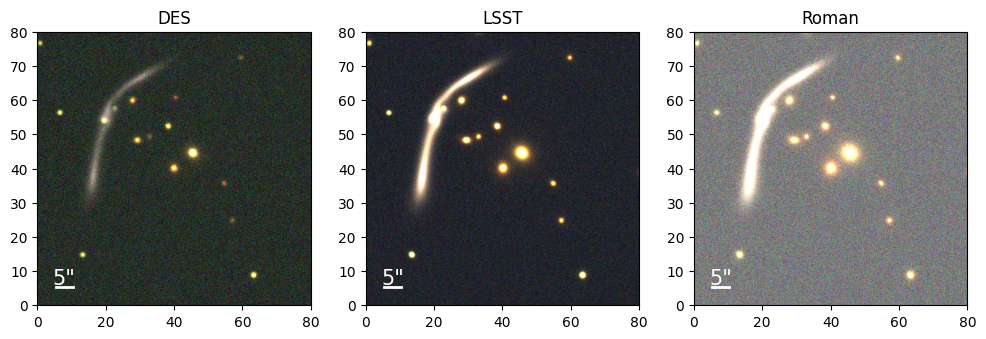

In [82]:
size = 80.0  # width of the image in units of arc seconds

img_des, coords_des = simulate_rgb(
    des, size=size, kwargs_numerics=kwargs_numerics, contrast=0.1
)
img_lsst, coords_lss = simulate_rgb(
    lsst, size=size, kwargs_numerics=kwargs_numerics, contrast=0.1
)
img_roman, coords_roman = simulate_rgb(
    roman, size=size, kwargs_numerics=kwargs_numerics, contrast=0.5
)

f, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.imshow(img_des, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("DES")
# coordinate_arrows(ax, d=1, coords=coords_des, color='w', font_size=15, arrow_size=0.05)
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)

ax = axes[1]
ax.imshow(img_lsst, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("LSST")
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)

ax = axes[2]
ax.imshow(img_roman, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("Roman")
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)
plt.show()